In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df = pd.read_csv('./data/okcupid_preprocessed.csv')
df = df.drop('Unnamed: 0', axis=1)

In [55]:
df.columns

Index(['sex', 'drinks', 'drugs', 'education', 'height', 'job', 'last_online',
       'smokes', 'Response rate', 'age', 'diet', 'total_essay_len',
       'essay_answered_count', 'is_churned', 'orientation_1', 'job_score',
       'stability_index', 'sign_1', 'body_type_average', 'body_type_curvy',
       'body_type_fit', 'body_type_slim', 'religion_religion',
       'status_encoding', 'ethnicity_black', 'ethnicity_hispanic / latin',
       'ethnicity_mixed', 'ethnicity_other', 'ethnicity_white',
       'dogs_encoding', 'cats_encoding', 'location_group_north_bay',
       'location_group_outside', 'location_group_sf',
       'location_group_south_bay', 'niche_score'],
      dtype='object')

In [56]:
df.head()

,sex,drinks,drugs,education,height,job,last_online,smokes,Response rate,age,...,ethnicity_mixed,ethnicity_other,ethnicity_white,dogs_encoding,cats_encoding,location_group_north_bay,location_group_outside,location_group_sf,location_group_south_bay,niche_score
0,1,0.0,0,1.0,75.0,transportation,2012-06-28,1.0,1.000000,22,...,True,False,False,1,1,False,False,False,True,5.0
1,1,1.0,1,NaN,70.0,hospitality / travel,2012-06-29,0.0,0.870968,35,...,False,False,True,1,1,False,False,False,False,1.0
2,1,0.0,0,3.0,68.0,NaN,2012-06-27,0.0,0.806452,38,...,False,False,False,0,1,False,False,True,False,0.0
3,1,0.0,0,1.0,71.0,student,2012-06-28,0.0,0.838710,23,...,False,False,True,0,1,False,False,False,False,1.0
4,1,0.0,0,2.0,66.0,artistic / musical / writer,2012-06-27,0.0,0.741935,29,...,True,False,False,1,1,False,False,True,False,0.0


In [57]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score

In [58]:
X = df.drop(['is_churned', 'last_online', 'ethnicity_black', 'ethnicity_hispanic / latin', 'ethnicity_mixed',
       'ethnicity_other', 'ethnicity_white', 'dogs_encoding', 'cats_encoding','location_group_north_bay', 'location_group_outside',
       'location_group_sf', 'location_group_south_bay', 'job'], axis=1) 
y = df['is_churned']

In [59]:
X.columns

Index(['sex', 'drinks', 'drugs', 'education', 'height', 'smokes',
       'Response rate', 'age', 'diet', 'total_essay_len',
       'essay_answered_count', 'orientation_1', 'job_score', 'stability_index',
       'sign_1', 'body_type_average', 'body_type_curvy', 'body_type_fit',
       'body_type_slim', 'religion_religion', 'status_encoding',
       'niche_score'],
      dtype='object')

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sex                   59934 non-null  int64  
 1   drinks                59934 non-null  float64
 2   drugs                 59934 non-null  int64  
 3   education             51629 non-null  float64
 4   height                59934 non-null  float64
 5   smokes                59934 non-null  float64
 6   Response rate         59934 non-null  float64
 7   age                   59934 non-null  int64  
 8   diet                  59934 non-null  int64  
 9   total_essay_len       59934 non-null  int64  
 10  essay_answered_count  59934 non-null  int64  
 11  orientation_1         59934 non-null  bool   
 12  job_score             59934 non-null  float64
 13  stability_index       51629 non-null  float64
 14  sign_1                59934 non-null  bool   
 15  body_type_average  

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
# XGBoost 모델 설정 변경
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=1.49  # 이 부분이 핵심!
)

xgb_model.fit(X_train, y_train)

# 다시 평가해보기
print("--- [optuna 적용 전 XGBoost 결과] ---")
print(classification_report(y_test, xgb_model.predict(X_test)))

c:\Users\kwonm\anaconda3\envs\mlstudy\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:15:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- [optuna 적용 전 XGBoost 결과] ---
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      7983
           1       0.51      0.41      0.45      4004

    accuracy                           0.67     11987
   macro avg       0.62      0.61      0.61     11987
weighted avg       0.66      0.67      0.66     11987



In [63]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        # 1. 트리 구조 최적화: 과적합 방지와 복잡도 사이의 균형
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05), # 조금 더 세밀하게
        
        # 2. 과적합 방지 파라미터 추가 (이게 중요합니다)
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        
        # 3. 가중치 범위 확장: 1.49가 정답 근처였으니 범위를 넓혀 탐색
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.2, 2.5),
        
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    # 학습/검증 데이터 분리 (교차 검증을 쓰면 더 좋지만 속도를 위해 분리형 사용)
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    model = XGBClassifier(**param)
    model.fit(X_train_sub, y_train_sub)
    
    preds = model.predict(X_val)
    
    # [핵심] 목적 함수 변경: 단순 Macro F1 대신 '이탈자(1)의 F1'에 가중치를 더 둡니다.
    # 이탈자를 놓치지 않으면서 전체적인 균형을 잡도록 유도합니다.
    f1_class1 = f1_score(y_val, preds, pos_label=1)
    f1_macro = f1_score(y_val, preds, average='macro')
    
    # 이탈자 F1과 전체 F1의 평균값을 극대화 (이탈자에 더 집중)
    return (f1_class1 + f1_macro) / 2

# 탐색 횟수를 100회로 늘려 더 깊게 찾습니다.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"최적의 혼합 F1 점수: {study.best_value}")
print(f"최적의 파라미터: {study.best_params}")

# 최적 파라미터로 최종 모델 학습
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

print("--- [새로운 Optuna 최적화 결과] ---")
print(classification_report(y_test, best_model.predict(X_test)))

[I 2026-02-23 17:15:30,468] A new study created in memory with name: no-name-6e4465d9-d8a5-4aa2-8869-9b181fdeffe4
[I 2026-02-23 17:15:31,806] Trial 0 finished with value: 0.5673368314404106 and parameters: {'n_estimators': 359, 'max_depth': 7, 'learning_rate': 0.03195171867941289, 'gamma': 0.942651885380883, 'subsample': 0.6458017086540891, 'colsample_bytree': 0.6737566888372801, 'scale_pos_weight': 2.2170239103090834}. Best is trial 0 with value: 0.5673368314404106.
[I 2026-02-23 17:15:33,038] Trial 1 finished with value: 0.5616772164192567 and parameters: {'n_estimators': 323, 'max_depth': 7, 'learning_rate': 0.028248253327662218, 'gamma': 0.5325442531777167, 'subsample': 0.8912092227544541, 'colsample_bytree': 0.7644758738628319, 'scale_pos_weight': 1.7137927652045915}. Best is trial 0 with value: 0.5673368314404106.
[I 2026-02-23 17:15:33,860] Trial 2 finished with value: 0.5385959133421172 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.020511485054886123,

최적의 혼합 F1 점수: 0.5752069584452084
최적의 파라미터: {'n_estimators': 380, 'max_depth': 6, 'learning_rate': 0.0184191171423868, 'gamma': 0.3519716944766795, 'subsample': 0.6742841679896163, 'colsample_bytree': 0.6988121643543566, 'scale_pos_weight': 2.0007982485617544}
--- [새로운 Optuna 최적화 결과] ---
              precision    recall  f1-score   support

           0       0.76      0.69      0.73      7983
           1       0.48      0.57      0.52      4004

    accuracy                           0.65     11987
   macro avg       0.62      0.63      0.63     11987
weighted avg       0.67      0.65      0.66     11987



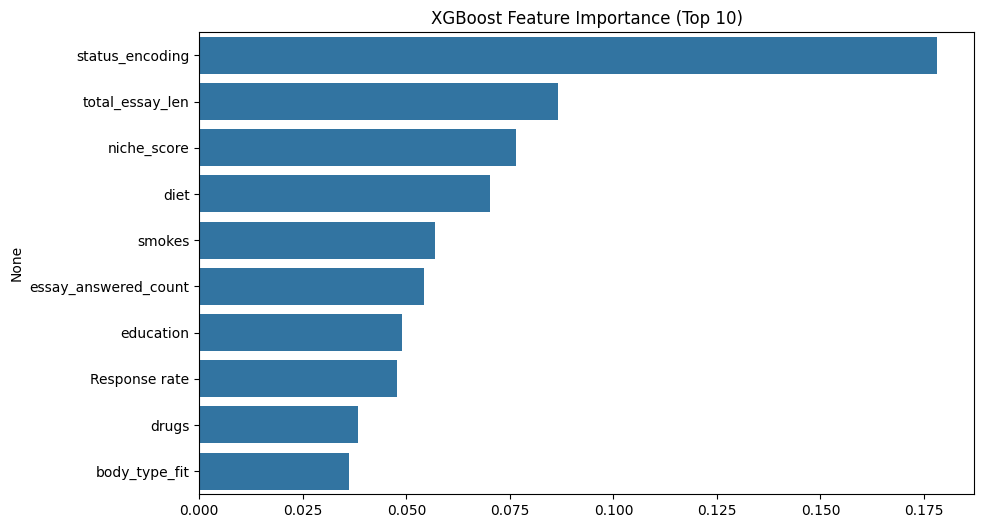

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost의 특성 중요도 추출
feature_imp = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.head(10).values, y=feature_imp.head(10).index)
plt.title('XGBoost Feature Importance (Top 10)')
plt.show()

In [65]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# 1. LightGBM 모델 초기화 및 학습
# is_unbalance=True: 클래스 불균형을 자동으로 가중치 조절해주는 아주 편리한 옵션입니다.
lgbm_model = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    is_unbalance=True, # XGBoost의 scale_pos_weight와 비슷한 역할
    learning_rate=0.05,
    boosting_type='gbdt'
)

lgbm_model.fit(X_train, y_train)

# 2. 결과 예측
lgbm_pred = lgbm_model.predict(X_test)

# 3. 성능 평가
print("--- [optuna 적용 전 LightGBM 결과] ---")
print(classification_report(y_test, lgbm_pred))

--- [optuna 적용 전 LightGBM 결과] ---
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      7983
           1       0.48      0.58      0.52      4004

    accuracy                           0.65     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.67      0.65      0.66     11987



In [66]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        
        # 1. 트리 복잡도 조절 (LGBM의 핵심)
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        
        # 2. 과적합 방지 및 데이터 샘플링
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        
        # 3. 가중치 조절 (XGBoost의 scale_pos_weight와 동일한 역할)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.2, 2.8),
        
        # 4. 정규화 (LGBM 성능 향상의 팁)
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }

    # 학습/검증 데이터 분리
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = LGBMClassifier(**param)
    model.fit(X_train_sub, y_train_sub)

    preds = model.predict(X_val)
    
    # [핵심] XGBoost와 동일한 이탈자 중심 가중치 목적 함수
    f1_class1 = f1_score(y_val, preds, pos_label=1)
    f1_macro = f1_score(y_val, preds, average='macro')
    
    return (f1_class1 + f1_macro) / 2

# 하이퍼파라미터 탐색 시작
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective, n_trials=100)

print(f"LGBM 최적의 혼합 F1 점수: {study_lgb.best_value}")
print(f"LGBM 최적의 파라미터: {study_lgb.best_params}")

# 최적 파라미터로 최종 모델 학습
best_lgb = LGBMClassifier(**study_lgb.best_params)
best_lgb.fit(X_train, y_train)

print("--- [최종 LightGBM 결과] ---")
print(classification_report(y_test, best_lgb.predict(X_test)))

[I 2026-02-23 17:17:18,146] A new study created in memory with name: no-name-30b78fe4-dc9b-4509-8595-00ed253c13f9


[I 2026-02-23 17:17:19,176] Trial 0 finished with value: 0.5641304275680104 and parameters: {'num_leaves': 93, 'max_depth': 5, 'learning_rate': 0.037974719479976465, 'n_estimators': 882, 'min_child_samples': 40, 'subsample': 0.7999816157037565, 'colsample_bytree': 0.6143612589874486, 'scale_pos_weight': 1.8673773558045639, 'reg_alpha': 0.0037962590627397433, 'reg_lambda': 0.19436611532884038}. Best is trial 0 with value: 0.5641304275680104.
[I 2026-02-23 17:17:20,392] Trial 1 finished with value: 0.5567076681279626 and parameters: {'num_leaves': 118, 'max_depth': 8, 'learning_rate': 0.009945433702110713, 'n_estimators': 461, 'min_child_samples': 45, 'subsample': 0.8103755871319503, 'colsample_bytree': 0.7691899325534608, 'scale_pos_weight': 2.4939854310562297, 'reg_alpha': 4.272192804274602, 'reg_lambda': 1.6300286972707327}. Best is trial 0 with value: 0.5641304275680104.
[I 2026-02-23 17:17:21,058] Trial 2 finished with value: 0.5596672046165885 and parameters: {'num_leaves': 22, 'ma

LGBM 최적의 혼합 F1 점수: 0.5743948625008493
LGBM 최적의 파라미터: {'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.019041917202878397, 'n_estimators': 459, 'min_child_samples': 17, 'subsample': 0.8078553724509621, 'colsample_bytree': 0.7330289670845331, 'scale_pos_weight': 2.04630150007745, 'reg_alpha': 0.2207598895930735, 'reg_lambda': 2.690550543858512}
--- [최종 LightGBM 결과] ---
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      7983
           1       0.48      0.59      0.53      4004

    accuracy                           0.65     11987
   macro avg       0.62      0.63      0.62     11987
weighted avg       0.67      0.65      0.65     11987



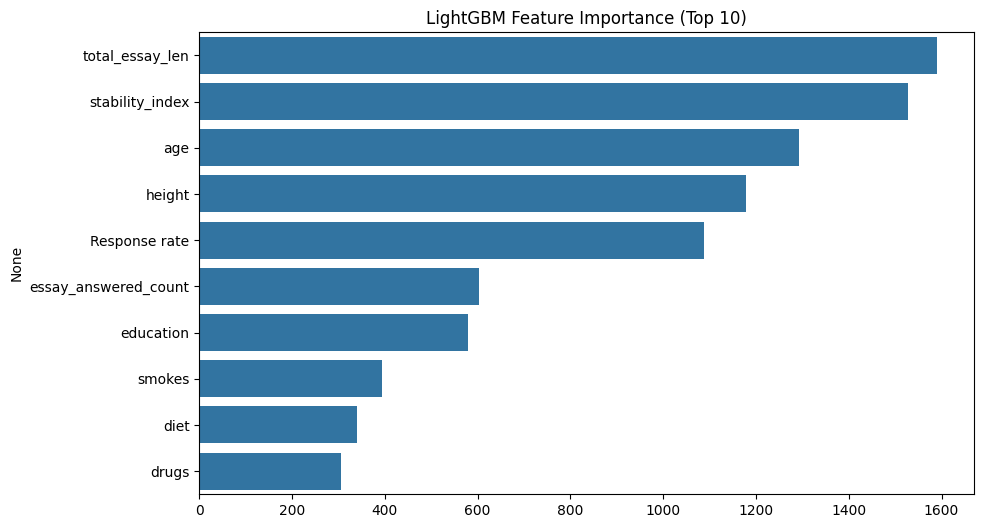

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM의 특성 중요도 추출
feature_imp = pd.Series(best_lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.head(10).values, y=feature_imp.head(10).index)
plt.title('LightGBM Feature Importance (Top 10)')
plt.show()